# Neural Network implementation for Racetime prediction

### Constants

In [17]:
DATA_DIR = "../data"

### Logger

In [18]:
import json
import os
from datetime import datetime
from pytorch_lightning.loggers import Logger
from pytorch_lightning.utilities.rank_zero import rank_zero_only

class F1NeuralNetworkExperimentsLogger2018(Logger):
    def __init__(self):
        super().__init__()
        self.metrics = []
        self.logs = {}
        self._version = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    @property
    def name(self):
        return "F1NeuralNetworkExperimentsLogger2018"

    @property
    def version(self):
        return self._version
    
    @rank_zero_only
    def log_model_architecture(self, model):
        architecture = str(model)
        self.logs['model_architecture'] = architecture

    @rank_zero_only
    def log_hyperparams(self, params):
        self.logs['hyperparameters'] = {k: str(v) for k, v in params.items()}

    @rank_zero_only
    def log_metrics(self, metrics, step):
        self.metrics.append((step, metrics))
        if 'metrics' not in self.logs:
            self.logs['metrics'] = []
        self.logs['metrics'].append({'step': step, 'metrics': {k: float(v) for k, v in metrics.items()}})

    @rank_zero_only
    def log_overall_test_loss(self, test_loss):
        self.logs['overall_test_loss'] = test_loss

    @rank_zero_only
    def log_used_features(self, features):
        self.logs['used_features'] = features

    @rank_zero_only
    def log_optimization_strategy(self, optimizer, scheduler):
        optimizer_str = str(optimizer)
        scheduler_str = str(scheduler)
        self.logs['optimizer'] = optimizer_str
        self.logs['scheduler'] = scheduler_str

    @rank_zero_only
    def save(self):
        directory = os.path.join(self.name, self.version)
        if not os.path.exists(directory):
            os.makedirs(directory)
        with open(os.path.join(directory, "logs.json"), "w") as f:
            json.dump(self.logs, f, indent=4)

    @rank_zero_only
    def finalize(self, status):
        self.save()

# Example usage
logger = F1NeuralNetworkExperimentsLogger2018()

### Select which features to use

#### Correlation between features

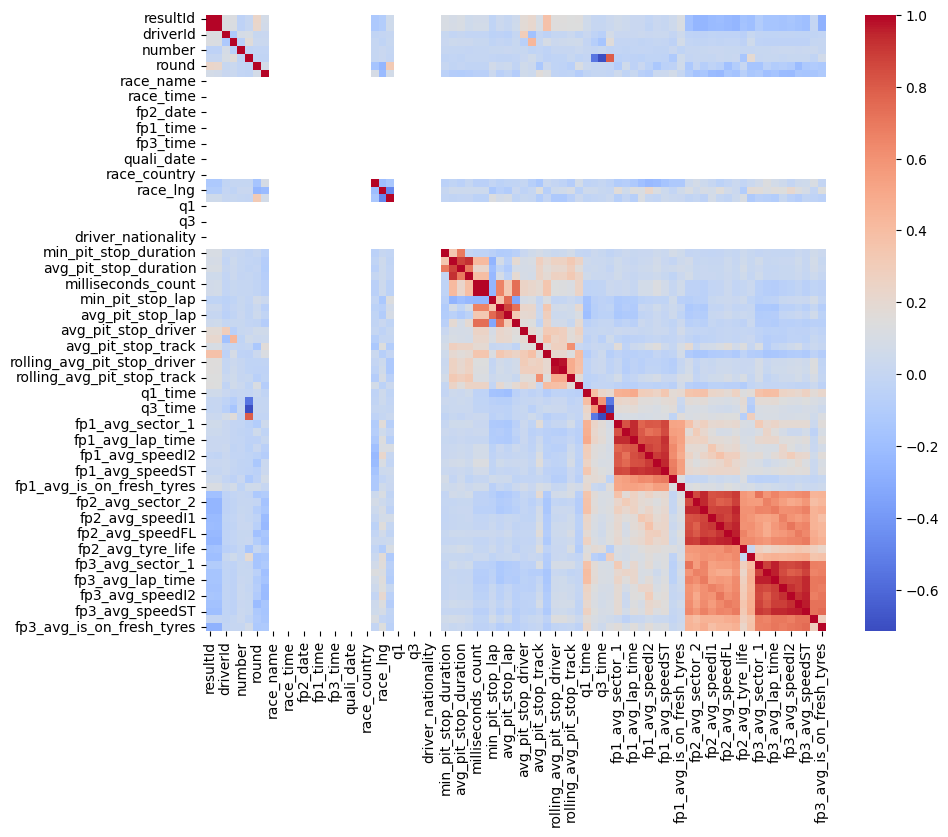

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

# Load the data
features_filepath = os.path.join(DATA_DIR, "train/train.csv")
labels_filepath = os.path.join(DATA_DIR, "train/train_labels.csv")
features = pd.read_csv(features_filepath)
labels = pd.read_csv(labels_filepath)

# Filter data for entries where the year is greater than 2018
features_filtered = features[features["year"] > 2018]

# Ensure all data is numeric and handle missing values
USED_FEATURES = features_filtered.columns.drop(['year'])
x = features_filtered[USED_FEATURES].apply(pd.to_numeric, errors='coerce').fillna(0)

# Normalize the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Create a DataFrame from the scaled data
df_scaled = pd.DataFrame(x_scaled, columns=USED_FEATURES)

# Calculate the correlation matrix
correlation_matrix = df_scaled.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

### Used features
Based on the heatmaps, I decided to use the following features.

In [20]:
USED_FEATURES = [
    "fp3_avg_is_on_fresh_tyres",
    "fp1_avg_sector_2",
    "fp1_avg_lap_time",
    "fp1_avg_speedST",
    "fp2_avg_sector_1",
    "fp2_avg_sector_2",
    "fp2_avg_lap_time",
    "fp2_avg_speedST",
    "fp3_avg_sector_1",
    "fp3_avg_sector_2",
    "fp3_avg_lap_time",
    "fp3_avg_speedST",
    "q1_time",
    "q2_time",
    "q3_time",
    "q_position",
    "min_pit_stop_duration",
    "avg_pit_stop_duration",
    "rolling_avg_pit_stop_driver",
    "rolling_avg_pit_stop_team",
    "race_lat",
    "race_lng",
    "race_alt",
    "race_date",
    "year",
    "round",
    "driver_nationality",
    "constructorId"
]
logger.log_used_features(USED_FEATURES)

### Dataset

In [21]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.preprocessing import StandardScaler

class F1Dataset(Dataset):
    def __init__(self, features_filepath, labels_filepath, year_from):
        super().__init__()
        self.year_from = year_from

        # Load the data
        features = pd.read_csv(features_filepath)
        labels = pd.read_csv(labels_filepath)

        # Filter data for entries where the year is greater than year_from
        features_filtered = features[features["year"] > self.year_from]
        labels_filtered = labels[features["year"] > self.year_from]

        # Ensure all data is numeric and handle missing values
        x = features_filtered[USED_FEATURES].apply(pd.to_numeric, errors='coerce').fillna(0)

        # Normalize the data
        scaler = StandardScaler()
        self.x = scaler.fit_transform(x)
        self.y = labels_filtered["positionOrder"].apply(pd.to_numeric, errors='coerce').fillna(0).to_numpy()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y

# Load the dataset
train_dataset = F1Dataset(os.path.join(DATA_DIR, "train/train.csv"), os.path.join(DATA_DIR, "train/train_labels.csv"), year_from=2018)
test_dataset = F1Dataset(os.path.join(DATA_DIR, "test/test.csv"), os.path.join(DATA_DIR, "test/test_labels.csv"), year_from=2018)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

data_2018_onwards = F1Dataset(
    os.path.join(DATA_DIR, "train/train.csv"),
    os.path.join(DATA_DIR, "train/train_labels.csv"),
    2018,
)

data_2018_onwards = F1Dataset(os.path.join(DATA_DIR, "train/train.csv"), os.path.join(DATA_DIR, "train/train_labels.csv"), 2018)
data_2018_onwards.__getitem__(0)

(tensor([-0.1783, -0.0217,  0.1952,  0.2937,  0.6286,  0.0737,  0.2614,  0.4071,
          1.2592,  0.9175,  1.0223,  0.1819, -0.0809,  0.4703, -0.9133,  0.3134,
         -0.1081, -0.2940, -0.5467, -0.5495,  0.6790,  0.0923,  0.0296,  0.0000,
          0.2573,  0.3394,  0.0000, -0.4276]),
 tensor(13.))

### Model

In [22]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt

class PositionPredictionModel(pl.LightningModule):
    def __init__(self, input_dim=len(USED_FEATURES), hidden_dim=64, output_dim=1, lr=1e-3, loss_fn=nn.L1Loss):
        super().__init__()
        self.save_hyperparameters(logger=True)
        self.predictions = []
        self.actuals = []
        self.train_losses = []
        self.val_losses = []
        self.test_losses = []
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            
            nn.Linear(hidden_dim, output_dim),
        )
        logger.log_model_architecture(self.model)
        
        self.lr = lr
        self.loss_fn = loss_fn()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x).squeeze(-1)  # Remove the extra dimension
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.train_losses.append(loss.item())
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x).squeeze(-1)  # Remove the extra dimension
        test_loss_fn = nn.MSELoss()
        loss = torch.sqrt(test_loss_fn(y_hat, y))
        self.predictions.extend(y_hat.cpu().numpy())
        self.actuals.extend(y.cpu().numpy())
        self.test_losses.append(loss.item())
        return loss

    
    def on_test_epoch_end(self):
        # Calculate and log the average test loss
        avg_test_loss = sum(self.test_losses) / len(self.test_losses)
        print(f"Average Test Loss: {avg_test_loss}")
        logger.log_overall_test_loss(avg_test_loss)
        
        # Plot the correlation between actual and predicted values
        plt.figure(figsize=(8, 6))
        plt.scatter(self.actuals, self.predictions, alpha=0.6, edgecolor='k')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Correlation between Actual and Predicted Values')
        plt.grid(True)
        plt.show()
        
        # Plot the loss curve
        self.plot_loss_curve()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters())
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.lr,
            steps_per_epoch=100,
            epochs=10,
            anneal_strategy='cos',
        )
        logger.log_optimization_strategy(str(optimizer), str(scheduler))
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

    def plot_loss_curve(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

model = PositionPredictionModel()
model

PositionPredictionModel(
  (model): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=128, out_features=64, bias=True)
    (17): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=Tr

### Training

In [23]:
trainer = pl.Trainer(max_epochs=50, logger=logger)
trainer.fit(model, train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 85.7 K | train
1 | loss_fn | L1Loss     | 0      | train
-----------------------------------------------
85.7 K    Trainable params
0         Non-trainable params
85.7 K    Total params
0.343     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode
/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


### Evaluation

/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Average Test Loss: 4.970153945391296


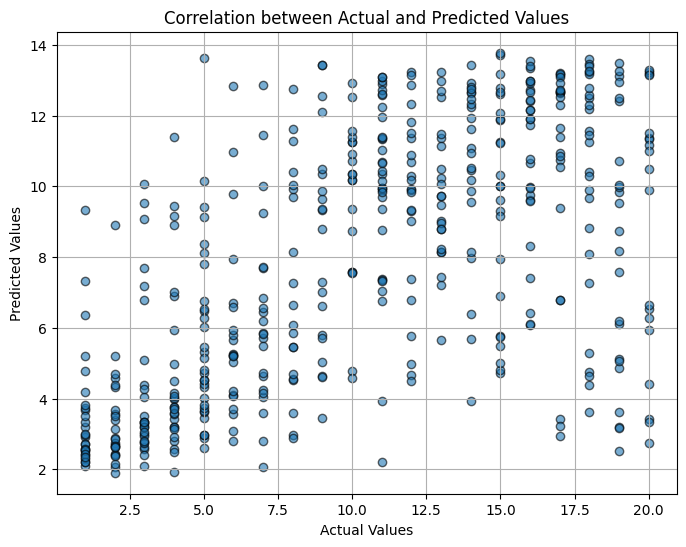

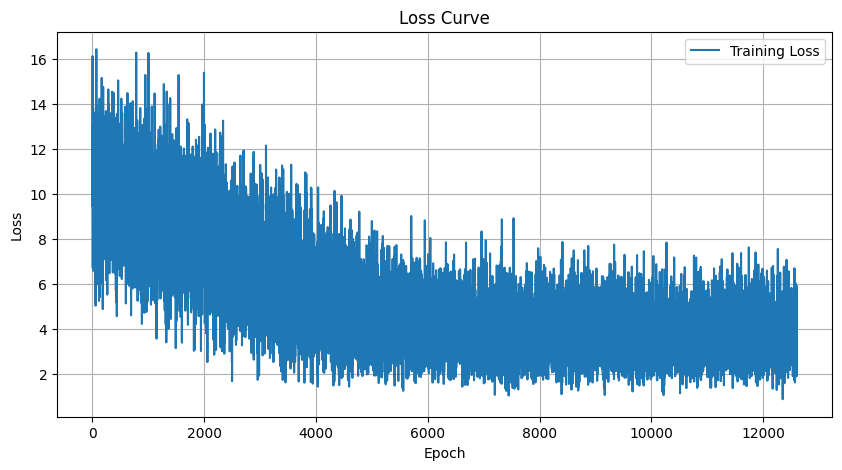

[{}]

In [24]:
trainer.test(model, test_loader)